### FBP method: Ramp Filter is one of key points

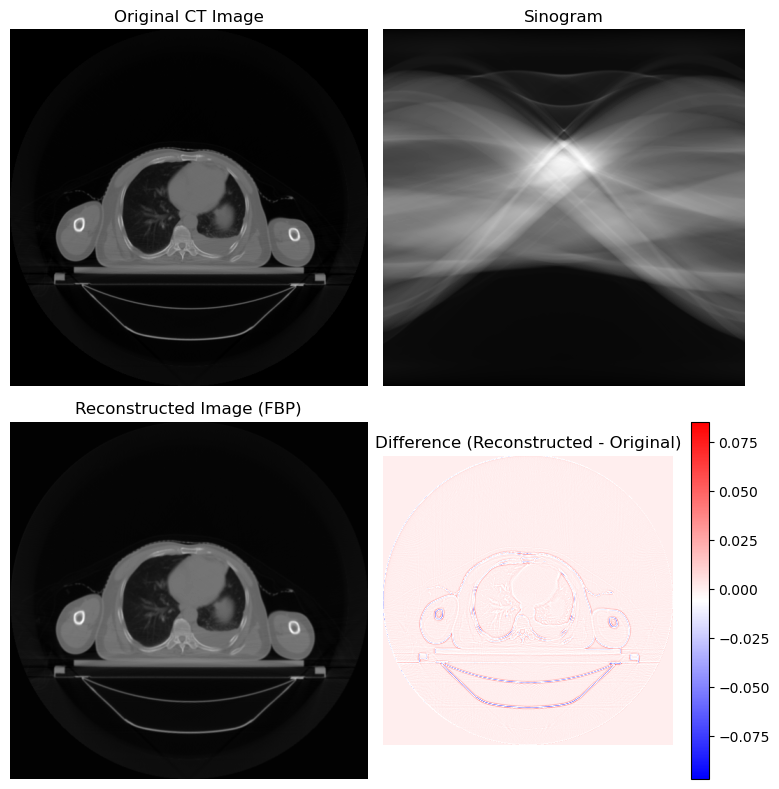

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from skimage.transform import radon, iradon

# FBP 重建函数
def fbp_reconstruction(ct_filepath):
    # 1. 读取 DICOM 文件
    dicom_data = pydicom.dcmread(ct_filepath)
    image = dicom_data.pixel_array

    # 2. 归一化图像（如果需要）
    image = image / np.max(image)

    # 3. 计算 sinogram（Radon Transform）
    theta = np.linspace(0., 180., max(image.shape), endpoint=False)
    sinogram = radon(image, theta=theta, circle=True)

    # 4. 滤波后进行反投影（Filtered Back Projection）
    reconstructed_image = iradon(sinogram, theta=theta, circle=True, filter_name='ramp')

    # 5. 计算差异图像
    difference = reconstructed_image - image

    # 6. 绘图可视化
    plt.figure(figsize=(8, 8))

    # 原图
    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original CT Image')
    plt.axis('off')

    # Sinogram
    plt.subplot(2, 2, 2)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.title('Sinogram')
    plt.axis('off')

    # 重建图像
    plt.subplot(2, 2, 3)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title('Reconstructed Image (FBP)')
    plt.axis('off')

    # 差异图像
    plt.subplot(2, 2, 4)
    plt.imshow(difference, cmap='bwr')
    plt.title('Difference (Reconstructed - Original)')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 示例：运行代码
# 请在此处输入你的 DICOM 文件路径
ct_filepath = r"D:\WCH_TPS\patient\ProtonPlan\Lung\CT1.2.752.243.1.1.20191027213600427.5400.13601.dcm"
fbp_reconstruction(ct_filepath)

In [2]:
import os

original_path = os.environ.get("PATH")
custom_path = r"C:\Users\47348\anaconda3\envs\reconstruction\Library\bin"
os.environ["PATH"] = f"{custom_path};{original_path}"

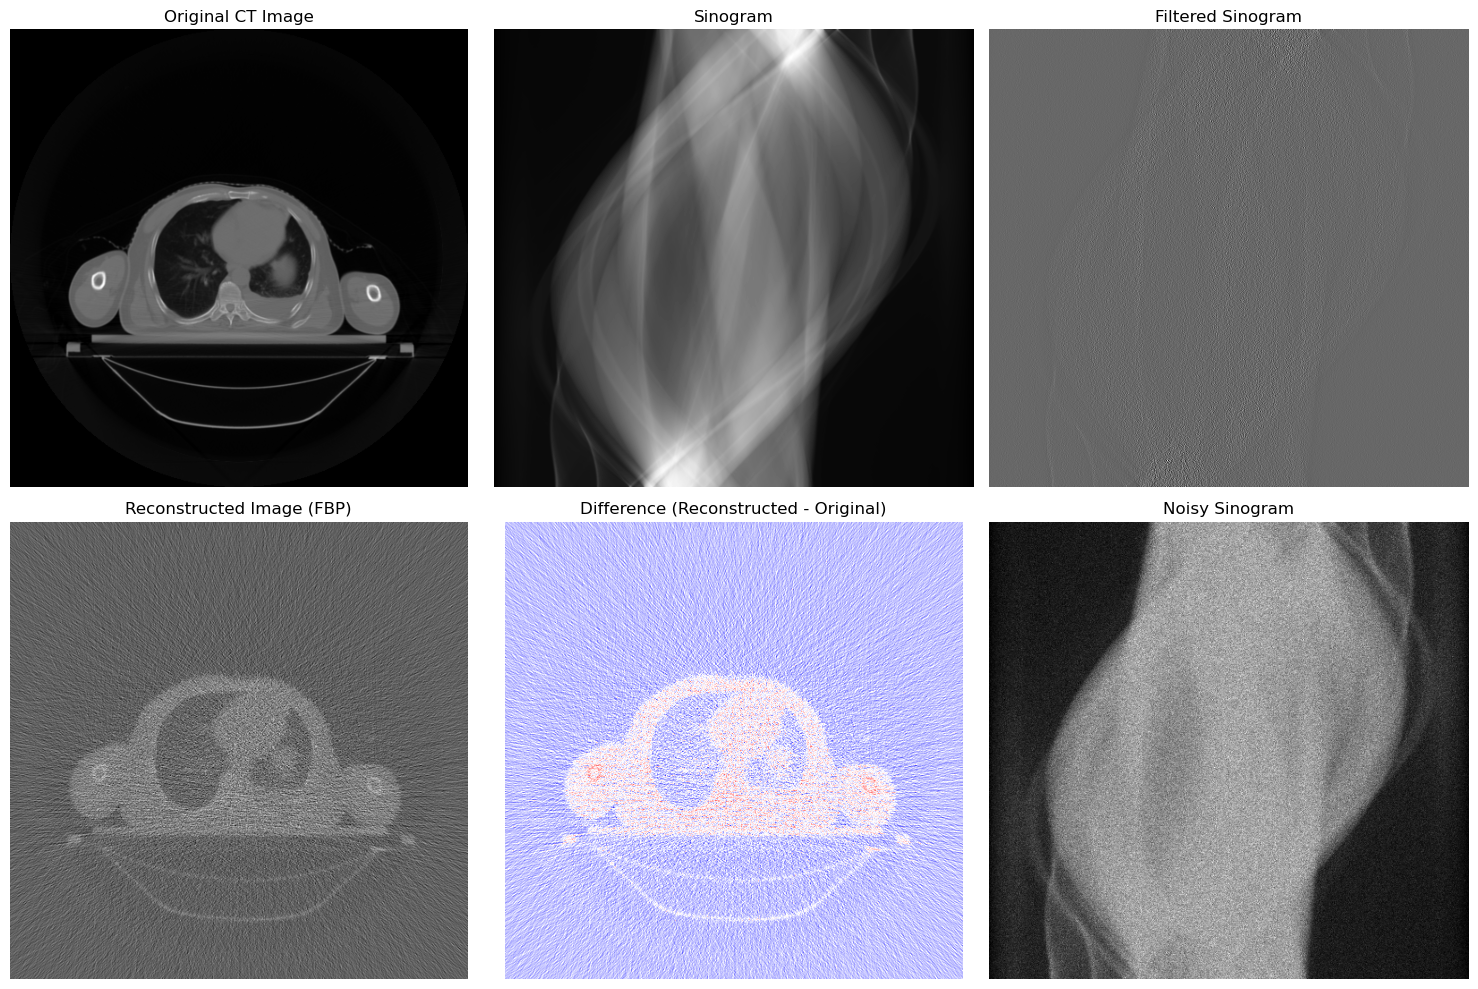

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import parallelproj
from scipy.ndimage import gaussian_filter
import pydicom

def fbp_reconstruction(ct_filepath):
    """
    Perform FBP reconstruction using tools from parallelproj and custom filtering.

    Parameters:
    - ct_filepath: Path to the input CT DICOM file.
    """
    # 1. Load CT image from DICOM file
    dicom_data = pydicom.dcmread(ct_filepath)
    image = dicom_data.pixel_array
    image = image.astype(np.float32)  # Ensure the image is in float format
    image = image / np.max(image)  # Normalize the image

    # 2. Define parameters
    image_shape = image.shape
    total_counts = 1e7
    max_angle = np.pi
    detector_bins = image_shape[1] # 512
    total_angles = (int(0.5 * detector_bins * np.pi * (max_angle / np.pi)) + 1) // 3  # Undersampling factor = 3

    r = np.linspace(-30, 30, detector_bins)
    theta = np.linspace(0, max_angle, total_angles, endpoint=False)

    # 3. Create ParallelViewProjector2D
    proj = parallelproj.ParallelViewProjector2D(
        image_shape, r, -theta, 2 * float(np.max(r)),
        (float(np.min(r)), float(np.min(r))),
        (float(r[1] - r[0]), float(r[1] - r[0]))
    )

    # 4. Forward projection (sinogram)
    sinogram = proj(image)

    # 5. Simulate corrections and filtering
    mu = 0.096
    attenuation = np.exp(-mu * proj(image))
    emission_sinogram = attenuation * sinogram
    contamination = 0.1 * np.mean(emission_sinogram)
    contamination_array = np.full(emission_sinogram.shape, contamination)

    # Apply Gaussian blur
    for i in range(total_angles):
        emission_sinogram[:, i] = gaussian_filter(emission_sinogram[:, i], 1.5)

    # Scale to total counts and add Poisson noise
    scale_factor = total_counts / np.sum(emission_sinogram)
    emission_sinogram *= scale_factor
    contamination_array *= scale_factor
    noisy_sinogram = np.random.poisson(emission_sinogram).astype(np.float32)

    # Correct the sinogram
    corrected_sinogram = (noisy_sinogram - contamination_array) / attenuation

    # Create and apply ramp filter
    N = r.shape[0]
    freq_index = np.arange(N) - N // 2
    ramp_filter = np.zeros(N, dtype=np.float64)
    ramp_filter[freq_index != 0] = -1 / (np.pi**2 * freq_index[freq_index != 0] ** 2)
    ramp_filter[(freq_index % 2) == 0] = 0
    ramp_filter[freq_index == 0] = 0.25


    filtered_sinogram = corrected_sinogram.copy()
    for i in range(total_angles):
        filtered_sinogram[:, i] = np.convolve(filtered_sinogram[:, i], ramp_filter, mode="same")

    # 6. Backprojection (FBP)
    reconstructed_image = proj.adjoint(filtered_sinogram)
    difference_image = reconstructed_image - image

    # 7. Visualization
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].imshow(image, cmap="gray")
    axs[0, 0].set_title("Original CT Image")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(sinogram.T, cmap="gray", aspect="auto")
    axs[0, 1].set_title("Sinogram")
    axs[0, 1].axis("off")

    axs[0, 2].imshow(filtered_sinogram.T, cmap="gray", aspect="auto")
    axs[0, 2].set_title("Filtered Sinogram")
    axs[0, 2].axis("off")

    axs[1, 0].imshow(reconstructed_image, cmap="gray")
    axs[1, 0].set_title("Reconstructed Image (FBP)")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(difference_image, cmap="bwr")
    axs[1, 1].set_title("Difference (Reconstructed - Original)")
    axs[1, 1].axis("off")

    axs[1, 2].imshow(noisy_sinogram.T, cmap="gray", aspect="auto")
    axs[1, 2].set_title("Noisy Sinogram")
    axs[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
ct_filepath = r"D:\WCH_TPS\patient\ProtonPlan\Lung\CT1.2.752.243.1.1.20191027213600427.5400.13601.dcm"
fbp_reconstruction(ct_filepath)